### Restaurant and Bar Employment Growth as Share of Total

In [1]:
import requests
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import config

%matplotlib inline

In [2]:
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
key = '?registrationkey={}'.format(config.bls_key)
headers = {'Content-type': 'application/json'}
series_dict = {
    'TOT_NFP': 'CES0000000001',
    'FSD_NFP': 'CES7072200001',
    'AFS_NFP': 'CES7072000001',
    'MFN_NFP': 'CES3000000001',
    'FSD_AHE': 'CES7072200008',
    'AFS_AHE': 'CES7072000008',
    'TOT_AHE': 'CES0500000008',
    'MFN_AHE': 'CES3000000008',
    'AFS_QU': 'JTS72000000QUR',
    'TOT_QU': 'JTS00000000QUR',
    'FSD_HRS': 'CES7072200002',
    'MFN_HRS': 'CES3000000002',
    'TOT_HRS': 'CES0500000002',
}
inv_map = {v: k for k, v in series_dict.iteritems()}
series_list = series_dict.values()  # Take just the series codes as a list

date_list = [("1980", "1988"),("1989", "1998"), ("1999", "2008"), ("2009", "2017")]
df = pd.DataFrame()

In [3]:
for start, end in date_list:
    data = json.dumps({"seriesid":series_list, "startyear":start, "endyear":end})
    json_data = requests.post('{}{}'.format(url, key), headers=headers, data=data).json()
    # Store the relevant information in a dictionay and combine into a pandas dataframe
    d = {}
    for series in json_data['Results']['series']:
        seriesId = series['seriesID']
        d[seriesId] = pd.DataFrame(series['data'])
        if len(series['data']) > 0:
            # Convert BLS API dates to readable format (YYYY-MM-DD)
            d[seriesId]['date'] = pd.to_datetime(d[seriesId]['period'] + ' ' + d[seriesId]['year'])
            # Keep only date and series values
            d[seriesId] = d[seriesId].sort_values(by='date')[['date', 'value']].set_index('date')
            # Rename and round
            d[seriesId] = d[seriesId]['value'].rename(inv_map[seriesId]).astype(float)
        else:
            d[seriesId]['date'] = pd.Series()
            d[seriesId]['value'] = pd.Series()
            d[seriesId] = d[seriesId]['value'].rename(inv_map[seriesId])
    df = df.append(pd.concat([d[series_list[x]] for x in range(len(d))], axis=1))

In [4]:
df['OTH_NFP'] = df['TOT_NFP'] - df['FSD_NFP']
for series in ['AFS_NFP', 'FSD_NFP', 'TOT_NFP', 'OTH_NFP', 'MFN_NFP']:
    df[series+'_12ch'] = df[series].diff(12)
    df[series+'_ch'] = df[series].diff()
    df[series+'_12_pct_ch'] = df[series].pct_change(12).multiply(100)
    # Indexed to end of Great Recession
    df[series+'_index'] = df[series] / df.loc['2009-06-01'][series] * 100
    df[series+'_index1'] = df[series] / df.loc['1980-01-01'][series] * 100
for series in ['AFS_AHE', 'FSD_AHE', 'TOT_AHE']:
    df[series+'_12_pct_ch'] = df[series].pct_change(12).multiply(100)    

In [5]:
df.to_csv('Restaurant_Jobs.csv')

In [6]:
# Select relevant columns to plot and rename them
slist = ['FSD_NFP_index1', 'MFN_NFP_index1', 'TOT_NFP_index1']

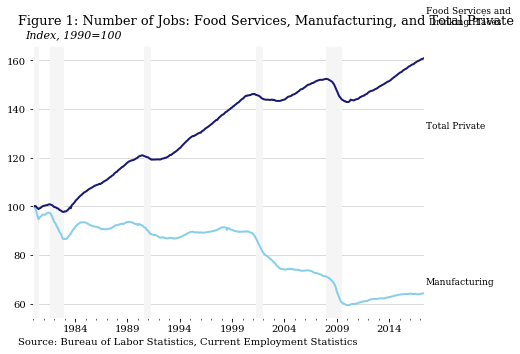

In [7]:
matplotlib.rc('axes',edgecolor='white')
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

df[slist].plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'skyblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
plt.text(570, 175, 'Food Services and \n Drinking Places', size=9)
plt.text(570, 132, 'Total Private', size=9)
plt.text(570, 68, 'Manufacturing', size=9)
plt.annotate('Figure 1: Number of Jobs: Food Services, Manufacturing, and Total Private', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Index, 1990=100', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.savefig('jobs_index.png', bbox_inches='tight')

In [8]:
df.keys()

Index([u'TOT_HRS', u'AFS_QU', u'TOT_NFP', u'TOT_AHE', u'MFN_HRS', u'FSD_HRS',
       u'MFN_NFP', u'FSD_NFP', u'AFS_NFP', u'TOT_QU', u'AFS_AHE', u'MFN_AHE',
       u'FSD_AHE', u'OTH_NFP', u'AFS_NFP_12ch', u'AFS_NFP_ch',
       u'AFS_NFP_12_pct_ch', u'AFS_NFP_index', u'AFS_NFP_index1',
       u'FSD_NFP_12ch', u'FSD_NFP_ch', u'FSD_NFP_12_pct_ch', u'FSD_NFP_index',
       u'FSD_NFP_index1', u'TOT_NFP_12ch', u'TOT_NFP_ch', u'TOT_NFP_12_pct_ch',
       u'TOT_NFP_index', u'TOT_NFP_index1', u'OTH_NFP_12ch', u'OTH_NFP_ch',
       u'OTH_NFP_12_pct_ch', u'OTH_NFP_index', u'OTH_NFP_index1',
       u'MFN_NFP_12ch', u'MFN_NFP_ch', u'MFN_NFP_12_pct_ch', u'MFN_NFP_index',
       u'MFN_NFP_index1', u'AFS_AHE_12_pct_ch', u'FSD_AHE_12_pct_ch',
       u'TOT_AHE_12_pct_ch'],
      dtype='object')

In [9]:
slist2 = ['FSD_NFP_12_pct_ch', 'OTH_NFP_12_pct_ch']

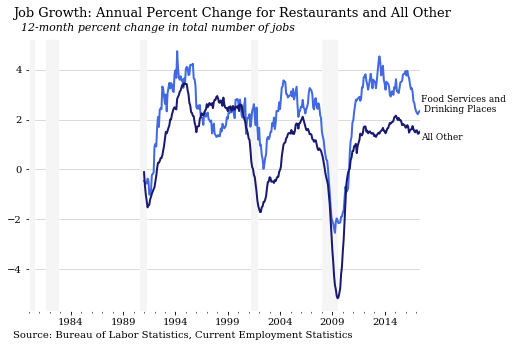

In [10]:
matplotlib.rc('axes',edgecolor='white')
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

df[slist2].plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
plt.text(570, 2.3, 'Food Services and \n Drinking Places', size=9)
plt.text(570, 1.2, 'All Other', size=9)
#plt.text(570, 68, 'Manufacturing', size=9)
plt.annotate('Job Growth: Annual Percent Change for Restaurants and All Other', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('12-month percent change in total number of jobs', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.savefig('jobs_growth_rate.png', bbox_inches='tight')

In [11]:
slist3 = ['FSD_AHE_12_pct_ch', 'TOT_AHE_12_pct_ch']

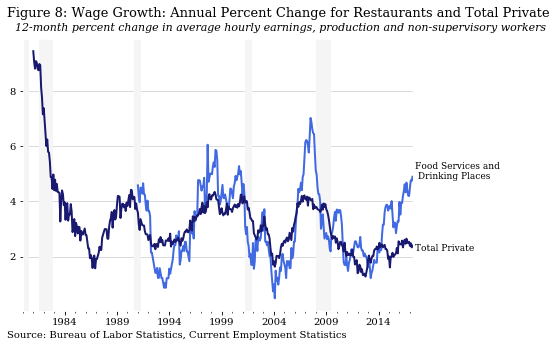

In [12]:
matplotlib.rc('axes',edgecolor='white')
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

df[slist3].plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
plt.text(570, 4.8, 'Food Services and \n Drinking Places', size=9)
plt.text(570, 2.2, 'Total Private', size=9)
#plt.text(570, 68, 'Manufacturing', size=9)
plt.annotate('Figure 8: Wage Growth: Annual Percent Change for Restaurants and Total Private', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('12-month percent change in average hourly earnings, production and non-supervisory workers', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.savefig('wage_growth.png', bbox_inches='tight')

In [13]:
slist4 = ['AFS_QU', 'TOT_QU']

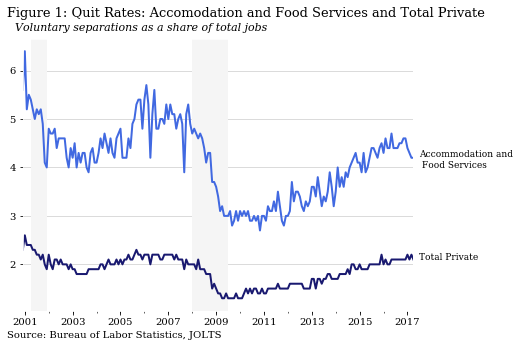

In [14]:
matplotlib.rc('axes',edgecolor='white')
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

df[slist4].dropna().plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
plt.text(570, 4.0, 'Accommodation and \n Food Services', size=9)
plt.text(570, 2.1, 'Total Private', size=9)
#plt.text(570, 68, 'Manufacturing', size=9)
plt.annotate('Figure 1: Quit Rates: Accomodation and Food Services and Total Private', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Voluntary separations as a share of total jobs', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, JOLTS', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.savefig('quit_rates.png', bbox_inches='tight')

### Calculations

In [15]:
d = {}
for date in ['1990-01-01', '2000-01-01', '2010-01-01', '2017-05-01']:
    year = date[:4]
    d[year] = df.loc[date]['FSD_NFP'] / df.loc[date]['TOT_NFP'] * 100
share = pd.DataFrame(d, index=[0]).T

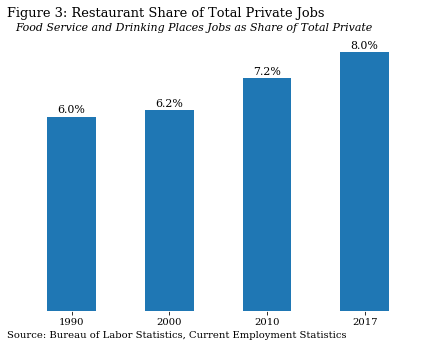

In [16]:
plt.rcParams['ytick.color'] = 'white'
share.plot(figsize=(7, 5), kind='bar', legend=None)
plt.xticks(rotation=0)
plt.yticks(color='white')
#plt.grid(axis='y', color='lightgray')
for i, txt in enumerate(share[0]):
    plt.annotate('{}%'.format(round(txt,1)), (i,txt+0.1), ha='center', size=11)
plt.annotate('Figure 3: Restaurant Share of Total Private Jobs', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Food Service and Drinking Places Jobs as Share of Total Private', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.savefig('rest_share_total.png', bbox_inches='tight')

In [17]:
date_ranges = [('1990-02-01', '1999-12-01'),('2000-01-01', '2007-12-01'),('2008-01-01', '2017-05-01')]
d = {}
for start, end in date_ranges:
    d_range = '{}-{}'.format(start[:4], end[:4])
    d[d_range] = df['FSD_NFP'].diff().dropna().loc[start:end].values.sum() / df['TOT_NFP'].diff().dropna().loc[start:end].values.sum() * 100
g_share = pd.DataFrame(d, index=[0]).T

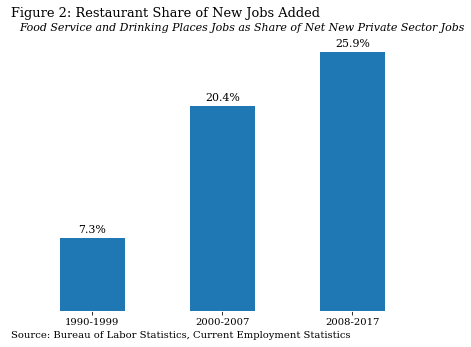

In [18]:
plt.rcParams['ytick.color'] = 'white'
g_share.plot(figsize=(7, 5), kind='bar', legend=None)
plt.xticks(rotation=0)
plt.yticks(color='white')
#plt.grid(axis='y', color='lightgray')
for i, txt in enumerate(g_share[0]):
    plt.annotate('{}%'.format(round(txt,1)), (i,txt+0.5), ha='center', size=11)
plt.annotate('Figure 2: Restaurant Share of New Jobs Added', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Food Service and Drinking Places Jobs as Share of Net New Private Sector Jobs', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.savefig('rest_share_new.png', bbox_inches='tight')

In [19]:
slist5 = ['FSD_AHE', 'TOT_AHE', 'MFN_AHE']
slist6 = ['FSD_HRS', 'TOT_HRS', 'MFN_HRS']

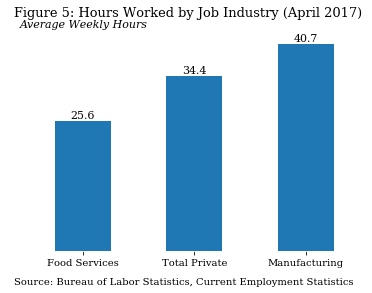

In [20]:
hrs = df[slist6].loc['2017-04-01']
hrs.index = ['Food Services', 'Total Private', 'Manufacturing']
hrs.plot(kind='bar')
plt.xticks(rotation=0)
plt.yticks(color='white')
#plt.grid(axis='y', color='lightgray')
for i, txt in enumerate(hrs):
    plt.annotate('{}'.format(round(txt,1)), (i,txt+0.5), ha='center', size=11)
plt.annotate('Figure 5: Hours Worked by Job Industry (April 2017)', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Average Weekly Hours', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.15), xycoords='axes fraction')
plt.savefig('hours_by_job.png', bbox_inches='tight')

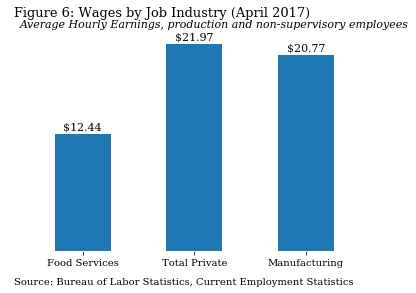

In [21]:
hrs = df[slist5].loc['2017-04-01']
hrs.index = ['Food Services', 'Total Private', 'Manufacturing']
hrs.plot(kind='bar')
plt.xticks(rotation=0)
plt.yticks(color='white')
#plt.grid(axis='y', color='lightgray')
for i, txt in enumerate(hrs):
    plt.annotate('${}'.format(round(txt,2)), (i,txt+0.5), ha='center', size=11)
plt.annotate('Figure 6: Wages by Job Industry (April 2017)', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Average Hourly Earnings, production and non-supervisory employees', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.15), xycoords='axes fraction')
plt.savefig('earnings_by_job.png', bbox_inches='tight')

In [22]:
url1 = 'https://download.bls.gov/pub/time.series/ee/ee.data.4.HistorySeasAE'
url2 = 'https://download.bls.gov/pub/time.series/ee/ee.data.1.CurrentSeasAE'
series = 'EES60580001'
df1 = pd.read_table(url1, sep='\s+').set_index('series_id').loc[series,:]
df2 = pd.read_table(url2, sep='\s+').set_index('series_id').loc[series,:]
df = df1.append(df2).reset_index()
# Clean up the date to convert it to pandas datetime
df.loc[:,'month'] = df['period'].replace(regex=True, 
                                         to_replace=r'M', 
                                         value=r'')
df.loc[:,'day'] = 1
df.loc[:,'date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index(['date'])['value']
df = df.rename(series)

In [23]:
df.to_csv('lt_rest.csv')

In [24]:
url1 = 'https://download.bls.gov/pub/time.series/ee/ee.data.56.TradeAHEHist'
url2 = 'https://download.bls.gov/pub/time.series/ee/ee.data.24.TradeAHECurr'
series = 'EEU60580006'
df1 = pd.read_table(url1, sep='\s+').set_index('series_id').loc[series,:]
df2 = pd.read_table(url2, sep='\s+').set_index('series_id').loc[series,:]
df = df1.append(df2).reset_index()[~df['period'].isin(['M13'])]
# Clean up the date to convert it to pandas datetime
df.loc[:,'month'] = df['period'].replace(regex=True, 
                                         to_replace=r'M', 
                                         value=r'')
df.loc[:,'day'] = '01'
df.loc[:,'date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index(['date'])['value']
df = df.rename(series)

KeyError: 'period'

In [ ]:
df.to_csv('lt_rest_ahe.csv')